In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf

import pixiedust
from functools import partial
import gin
import itertools
import multiprocessing
import pickle

from synthetic_data import xs_e, ys_e, Q1, xs, ys, A

# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

import seaborn as sns

Pixiedust database opened successfully


In [8]:
# hyperparameters setup
common = {
    'build_decoder_model.init_fp_dist': None,
    'build_feature_model.init_fp_dist': None,
    'build_reconstructor_model.init_fp_dist': None,
    'step.l_rec_coeff': 5,
    'get_results.epochs': 1000,
    'get_results.batch_size': 64,
    'step.optimizer': tf.keras.optimizers.Adam(lr=0.001),
    'get_results.step': 'step',
    'mask_step.mask': None,
    'step.l1_coeff': 0.0,
    'projection_step.l1_ball_size': None
}

sweep_00 = {
    'step.l_rec_coeff': [1, 10],
    'get_results.batch_size': [128],
    'repetitions': range(2),
    'name': ['sweep-00'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'get_results.batch_size'}],
}

sweep_01 = {
    'step.l_rec_coeff': np.logspace(-2, 2, 10),
    'get_results.batch_size': [64, 128, 256, 512],
    'repetitions': range(5),
    'name': ['sweep-01'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'get_results.batch_size'}],
}

sweep_02 = {
    'step.l1_coeff': np.logspace(-5, 2, 10),
    'step.l_rec_coeff': np.logspace(0, 1, 3),
    'get_results.batch_size': [128],
    'repetitions': range(5),
    'name': ['sweep-02'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'step.l1_coeff'}],
}

sweep_03 = {
    'compute_mask.components_to_keep': [4],
    'projection_step.l1_ball_size': [4.0],
    'mask_step.mask': [None],
    'step.l_rec_coeff': np.logspace(0, 1, 3),
    'get_results.batch_size': [128],
    'repetitions': range(5),
    'name': ['sweep-03'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'projection_step.l1_ball_size'}],
}

# number of processes
n_cpus = 5

sweep = sweep_03
assert 'name' in sweep
assert 'repetitions' in sweep
assert '_meta' in sweep
assert len(sweep['name']) == 1

In [3]:
# all parameters as a list
all_params = list(itertools.product(*[[(x, z) for z in y] for x, y in sweep.items()]))
all_params = [dict(t) for t in all_params]
print("Total runs: %d on %d CPUs" % (len(all_params), n_cpus))

Total runs: 15 on 5 CPUs


In [4]:
def set_params(param, synthetic_experiment_module):
    """Set params via gin."""
    # binding common params
    for k, v in common.items():
        if k == 'get_results.step':
            v = getattr(synthetic_experiment_module, v)
        gin.bind_parameter(k, v)
    
    for k, v in param.items():
        if k in ['repetitions', 'name', '_meta']: continue
        gin.bind_parameter(k, v)

def process_i(i):
    """Process i'th parameter."""
    param = all_params[i]
    print(i, param)
    import synthetic_experiment
    
    set_params(param, synthetic_experiment)
    
    return synthetic_experiment.get_results(xs_e, ys_e, Q1)

In [5]:
# RUNNING the experiment
pool = multiprocessing.Pool(n_cpus)
results = pool.map(process_i, range(len(all_params)))

4 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
2 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
3 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
0 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-03', '_meta


5 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}





6 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


7 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
8 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



9 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



10 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




11 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}

12 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


13 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



14 {'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/localhome/volodin/miniconda3/envs/causal/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/localhome/volodin/miniconda3/envs/causal/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/localhome/volodin/miniconda3/envs/causal/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/localhome/volodin/miniconda3/envs/causal/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/localhome/volodin/miniconda3/envs/causal/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/loc

In [9]:
def process_results(res, name):
    """Process experimental results."""
    print(name)
    losses, distances, weights = res
    # Plotting everything
    fig = plt.figure(figsize=(12, 4))
    fig.patch.set_facecolor('lightgreen')

    N_plots = len(losses) + 2

    plt.subplot(1, N_plots, 1)
    plt.title("d(M, A)")
    plt.plot(distances, color='red')
    plt.axhline(0, ls='--', c='black')

    colormap = ['green', 'blue', 'green', 'blue']

    # model losses
    for i, key in enumerate(losses.keys()):
        plt.subplot(1, N_plots, 2 + i)
        plt.title(key)
        plt.plot(losses[key], c=colormap[i])
        plt.axhline(0, ls='--', c='black')
    
    plt.subplot(1, N_plots, N_plots)
    plt.title("Weights heatmap")
    sns.heatmap(res[2]['model'][1])

    #plt.legend()
    plt.show()

In [10]:
param_1 = sweep['_meta'][0]['param_1']
param_2 = sweep['_meta'][0]['param_2']
assert param_1 in sweep and param_2 in sweep
lst_of_params = list(sweep.keys())
lst_of_params.remove(param_1)
lst_of_params.remove(param_2)
lst_of_params.remove('name')
print("Params 1: %s" % param_1)
print("Params 2: %s" % param_2)
print("Averaging over %s" % str(lst_of_params))

Params 1: step.l_rec_coeff
Params 2: projection_step.l1_ball_size
Averaging over ['compute_mask.components_to_keep', 'mask_step.mask', 'get_results.batch_size', 'repetitions', '_meta']


In [11]:
def filter_results(**kwargs):
    """Get results corresponding to constraints."""
    result = []
    for p, r in zip(all_params, results):
        include = True
        for k, v in kwargs.items():
            if p[k] != v: include = False
        if include:
            result.append((p, r))
    return result

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


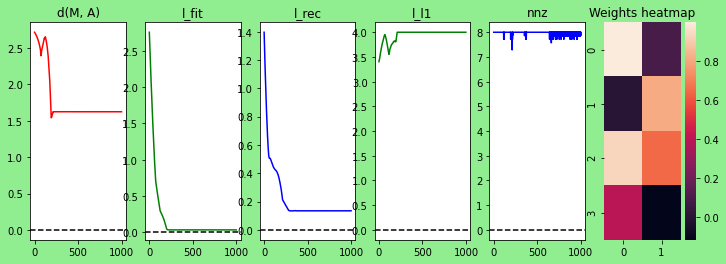

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


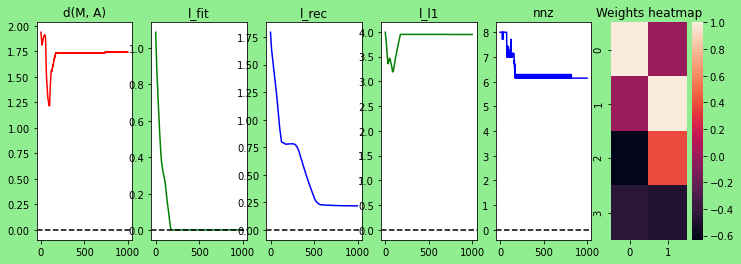

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


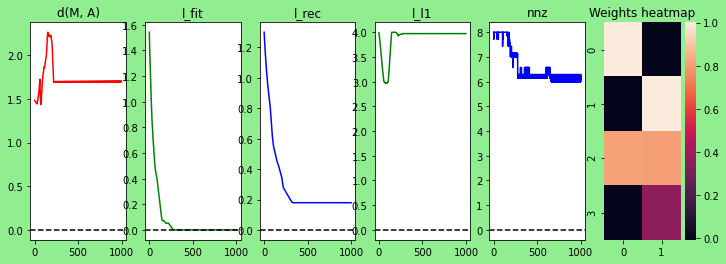

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


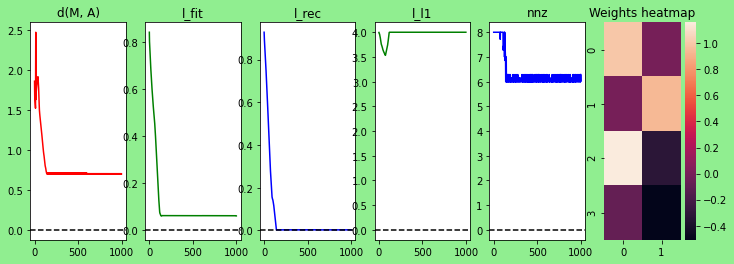

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


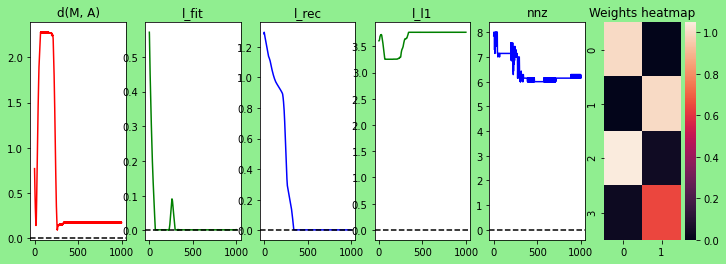

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


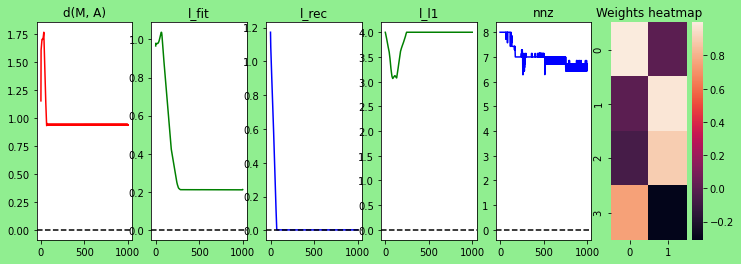

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


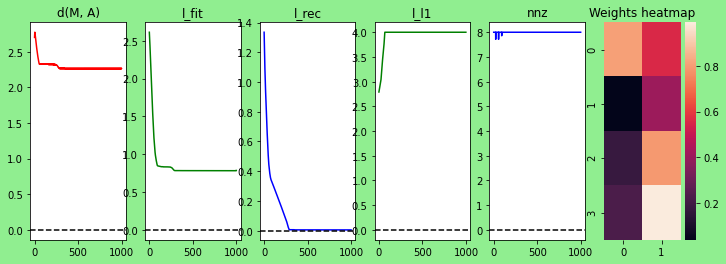

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


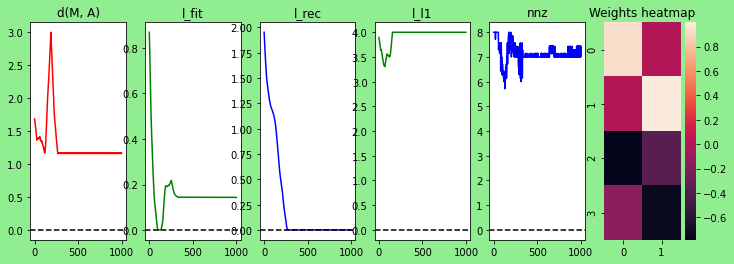

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


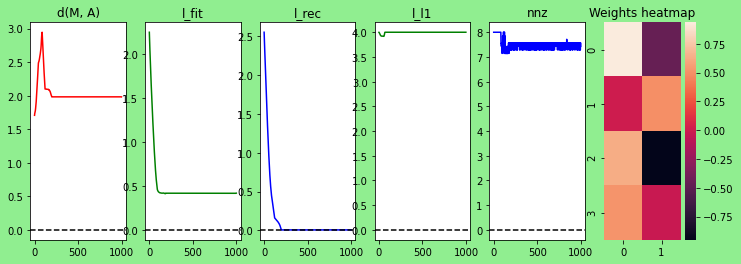

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


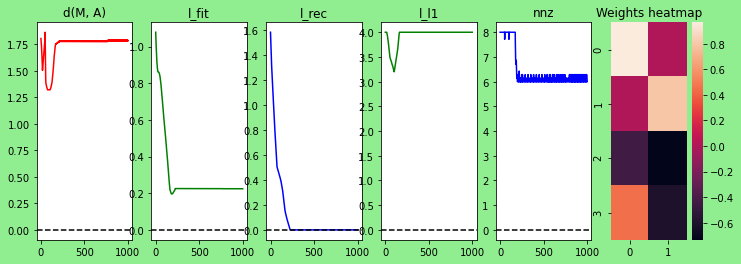

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


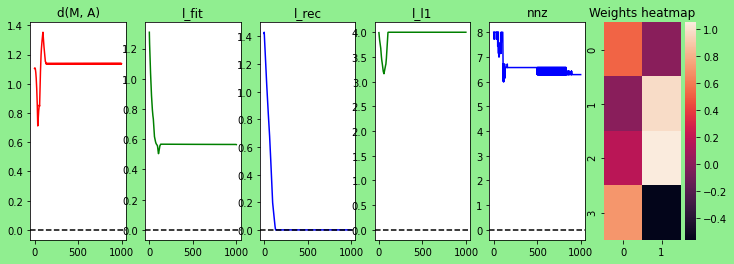

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


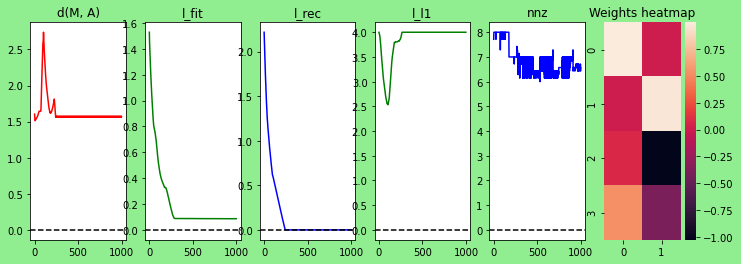

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


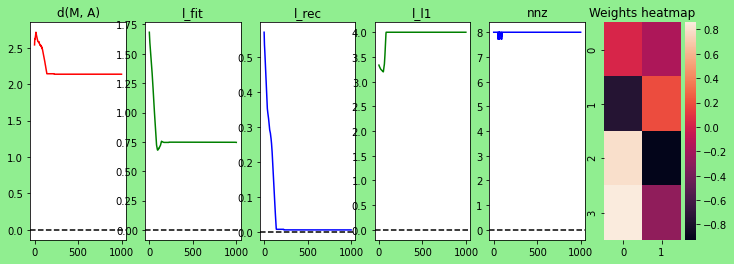

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


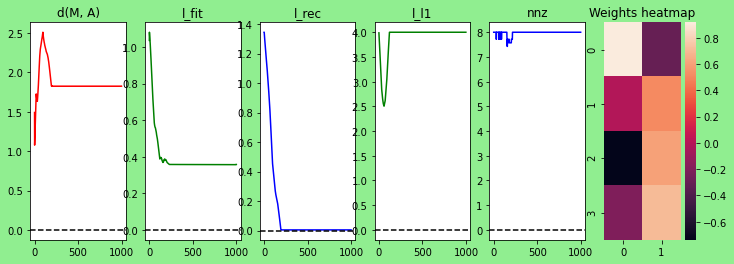

{'compute_mask.components_to_keep': 4, 'projection_step.l1_ball_size': 4.0, 'mask_step.mask': None, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-03', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


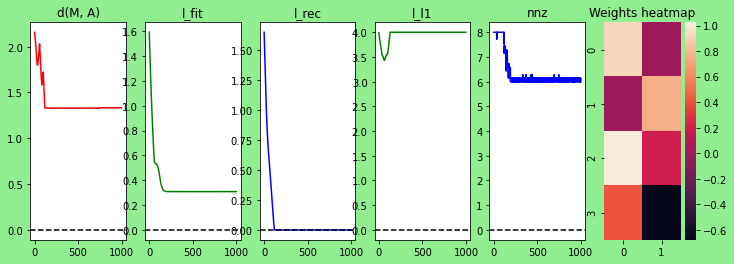

In [12]:
# show all results
for p, r in zip(all_params, results):
    process_results(r, str(p))

In [13]:
def quality_metric_last_l_fit(res):
    """Scalar quality metric: last fit loss."""
    #print(res)
    return res[1][0]['l_fit'][-1]

quality_metric_last_l_fit.title = "l_fit"

def quality_metric_last_l_rec(res):
    """Scalar quality metric: last rec loss."""
    #print(res)
    return res[1][0]['l_rec'][-1]

quality_metric_last_l_rec.title = "l_rec"

def quality_metric_last_l_l1(res):
    """Scalar quality metric: last rec loss."""
    #print(res)
    return res[1][0]['l_l1'][-1]

quality_metric_last_l_l1.title = "l_l1"

def quality_metric_last_de(res):
    """Scalar quality metric: last rec loss."""
    #print(res)
    return res[1][1][-1]

quality_metric_last_de.title = "de"

def quality_metric_combined(res):
    """Combined metric."""
    return max(quality_metric_last_l_fit(res), quality_metric_last_l_rec(res))
quality_metric_combined.title = "combined"

In [14]:
def plot_3d(metric):
    """Plot a metric in 3d."""
    # preparing data for the 3d plot
    X, Y, Z = [], [], []
    Xm, Ym, Zm = [], [], []
    Pm = []

    for p1 in sweep[param_1]:
        for p2 in sweep[param_2]:
            R = filter_results(**{param_1: p1, param_2: p2})
            for r in R:
                X.append(p1)
                Y.append(p2)
                Z.append(metric(r))
            Xm.append(p1)
            Ym.append(p2)
            Zm.append(np.median([metric(r) for r in R]))
            Pm.append((p1, p2))

    # Doing 3d plot

    # Configure the trace.
    trace1 = go.Mesh3d(x=Xm, y=Ym, z=Zm, opacity=0.5)

    # Configure the trace.
    trace2 = go.Scatter3d(x=X, y=Y, z=Z, opacity=0.5, mode='markers',
        marker={'size': 10, 'opacity': 0.8}
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace1, trace2]

    plot_figure = go.Figure(data=data, layout=layout)

    plot_figure.update_layout(scene = dict(xaxis_title=param_1,
                        yaxis_title=param_2,
                        zaxis_title=metric.title,
                        xaxis_type="log", yaxis_type="log"),
                        width=700,
                        margin=dict(r=20, b=10, l=10, t=10))


    # Render the plot.
    plotly.offline.iplot(plot_figure)
    
    return Zm, Pm

In [15]:
# l1rec now working??? well, yeah I use a custom training procedure...
Zm, Pm = plot_3d(quality_metric_combined)

In [16]:
# l1rec now working??? well, yeah I use a custom training procedure...
Zm, Pm = plot_3d(quality_metric_last_l_l1)

In [17]:
# l1rec now working??? well, yeah I use a custom training procedure...
Zm, Pm = plot_3d(quality_metric_last_de)

In [18]:
idx = np.argmin(Zm)
P = Pm[idx]
print("%s=%.2f, %s=%.2f metric=%.2f" % (param_1, P[0], param_2, P[1], Zm[idx]))

step.l_rec_coeff=10.00, projection_step.l1_ball_size=4.00 metric=1.57


In [19]:
# best parameters
best_param_idx = all_params.index(filter_results(**{param_1: P[0], param_2: P[1]})[0][0])
best_param = all_params[best_param_idx]

# RESULTS

`sweep_00`: best hyperparams l_rec_coeff=1, batch_size=256
`sweep_01`: works OK if bs <= 200 and l_re >= 1

# Manual computation

In [20]:
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()
import synthetic_experiment

1000/1000 [==============================] - 0s 41us/sample - loss: 0.0020
0.0019632669715210797
[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 9.9881494e-01, -1.0051029e-03],
       [-1.6619934e-03,  1.0007144e+00],
       [ 9.4156742e-01, -9.6443738e-04],
       [-2.2679050e-03,  9.7596157e-01]], dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.00273468, -0.00040425], dtype=float32)>]
0.09026993263978511


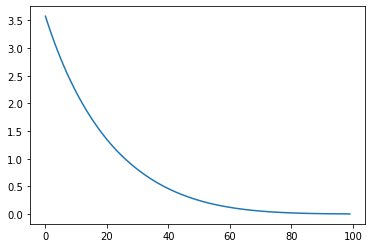

In [21]:
synthetic_experiment.fit_test_model(xs, ys, A)

In [31]:
# best_param = all_params[0]
set_params(best_param, synthetic_experiment)
set_params({'step.l_rec_coeff': 1}, synthetic_experiment)
best_param

{'compute_mask.components_to_keep': 4,
 'projection_step.l1_ball_size': 4.0,
 'mask_step.mask': None,
 'step.l_rec_coeff': 10.0,
 'get_results.batch_size': 128,
 'repetitions': 0,
 'name': 'sweep-03',
 '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}

In [50]:
# getting results manually
res = synthetic_experiment.get_results(xs_e, ys_e, Q1)

best


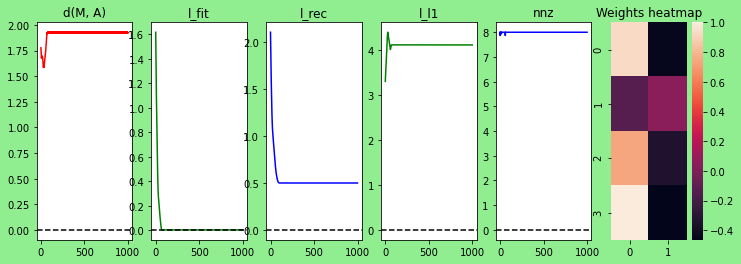

In [51]:
process_results(res, "best")

In [52]:
pickle.dump(results, open('results_%s.pkl' % sweep['name'][0], 'wb'))

In [ ]:
# Ideas:
# 1. try all 2^8 options as a mask . Is decoder unique for a model?
# 2. try |x_{4th element}| -> min -- automatic l0 sparsity if number of comp is known
# 3. evolution/discrete optimization
# 4. prior on weights of M -- two peaks in a histogram
# 5. batch size?
# 6. annealing method -- multiple steps ("day/night cycle") -- decrease/increase constraint with mask [1, eps], eps->0
#    "PID"(combined) -> annealing temperature eps; l1 ball radius
#    "PID"=moving average of last steps of the loss. high loss -> eventually temperature increases
#     loss is low -> increase temperature
#     stopping criteria: crisp abstracttions (develop sparseness metric -- low loss & eps=0)
# try increasing dimensionality of observations?..